The goal of this notebook is to build the model That we are Going to use for our tweet classification python program. We will then pickle the learned model to allow the program to call it to make predictions.

We start by importing all the necessary packages

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk import pos_tag, ne_chunk
import pickle
from sklearn.externals import joblib
import collections
import os
os.environ['JAVA_HOME'] = 'C:/Program Files (x86)/Java/jdk1.8.0_151'

In [2]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import History, Callback, ModelCheckpoint
from keras.utils import print_summary 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2, l1_l2
from sklearn import metrics
from keras import backend as K
import tensorflow as tf

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:

from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.utils import np_utils

We then load the data

In [4]:
data = pd.read_csv('../data/Airline-Tags.csv', header=0, encoding= "latin_1")

In [5]:
data[data['Tag'] == 'Late Flight'].head()

,_unit_id,_last_judgment_at,airline_sentiment,Tag,airline,Text,tweet_created,tweet_id
15,681448184,2/25/15 3:11,negative,Late Flight,Virgin America,@VirginAmerica SFO-PDX schedule is still MIA.,2/24/15 10:01,5.700000e+17
67,681448303,2/25/15 6:08,negative,Late Flight,Virgin America,"@VirginAmerica Hi, Virgin! I'm on hold for 40-...",2/23/15 13:35,5.700000e+17
82,681448334,2/25/15 4:13,negative,Late Flight,Virgin America,@VirginAmerica you're the best!! Whenever I (b...,2/23/15 10:54,5.700000e+17
93,681448360,2/25/15 3:30,negative,Late Flight,Virgin America,"@VirginAmerica just landed in LAX, an hour aft...",2/23/15 9:28,5.700000e+17
101,681448377,2/25/15 5:39,negative,Late Flight,Virgin America,@VirginAmerica why must a traveler miss a flig...,2/23/15 8:11,5.700000e+17


Since we are going to build a bag-of-word classifier, it is interesting to see which type of words appear in each class to get a sense of what the important features might be and what that of preprocessing might be needed.

In [6]:
list(data[data['Tag'] == 'Late Flight'].head()['Text'])

['@VirginAmerica SFO-PDX schedule is still MIA.',
 "@VirginAmerica Hi, Virgin! I'm on hold for 40-50 minutes -- are there any earlier flights from LA to NYC tonight; earlier than 11:50pm?",
 "@VirginAmerica you're the best!! Whenever I (begrudgingly) use any other airline I'm delayed and Late Flight :(",
 '@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin',
 '@VirginAmerica why must a traveler miss a flight to Late Flight check a bag?  I missed my morning appointments and you lost my business. #sfo2lax']

The dataset comes with multiple classes but since we are only interested in differenciating between tweets that are related to a late flight and tweets that are not, we are going to merge all the other classes together

In [7]:
data['Late_Flight'] = data['Tag'].apply(lambda x: 1 if x == 'Late Flight' else 0)

In order to create an efficient bag-of-word model, we need some preprocessing. This consist of removing useless information like punctiation, useless words and also tokenizing thewords. good exampleof meaningful tokenization include dates, times or usernames, for which each instance is probably going to be different but carry the same exact semantical meaning. Without reconciling them, we would not be able to learn anything forthem. This also allows us to reduce the size of the feature space which usually allows us to reduce the variance of a learned model.

To leverage the full extent of scikit learn tools for cross-validation and parameter tuning, it is useful to be able to include all of our preprocessing stepin the pipeline that is passed to the cross-validator. 

To do so, sciki-learn provides us the means to create our custom scikit-learn preprocessor. It requires at least a fit and a transform method. The preprocessor used here is taken from: https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html. I just added my custom regex-based tokenizationsteps to fit this particular dataset.




In [8]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True, remove_stopwords=True):
        self.lower      = lower
        self.strip      = strip
        self.remove_stopwords = remove_stopwords
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.dates = [
        'mon(?![a-z])', 'monday',
        'tues(?![a-z])', 'tuesday',
        'wednesday',
        'thur(?![a-z])', 'thurs', 'thursday',
        'fri(?![a-z])', 'friday',
        'saturday',
        'sunday'
    ]

    def fit(self, X, y=None):
        return self

    def join(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        l =  [
            list(self.tokenize(doc)) for doc in X
        ]
        return self.join(l)

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            sent_acc = self.replace_accounts(sent)
            sent_links = self.replace_links(sent_acc)
            sent_cities = self.replace_cities(sent_links)
            sent_times = self.replace_times(sent_cities)
            sent_delays = self.replace_delays(sent_times)
            sent_dates = self.replace_dates(sent_delays)
            sent_hashtags = self.replace_hashtags(sent_dates)
            sent_flight_numbers = self.replace_flight_numbers(sent_hashtags)
            for token, tag in pos_tag(wordpunct_tokenize(sent_flight_numbers)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token
    
                # If stopword, ignore token and continue
                if self.remove_stopwords:
                    if token in self.stopwords:
                        continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma
                
    def replace_accounts(self, sen):
        return re.sub('@[^ ]+', 'TOPERSON0', sen)
    
    def replace_links(self, sen):
        return re.sub('http[s]*[:][/]{2}[^ ]+', 'LINK0', sen)
    
    def replace_cities(self, sen):
        return re.sub('(?<![A-Z0-9])([A-Z]{2,3})(?![A-Z0-9])', 'CITY0', sen)
    
    def replace_times(self, sen):
        return re.sub('[0-9]{1,2}[:][0-9]{1,2}', ' TIME0 ', sen)
    def replace_delays(self, sen):
        return re.sub('[0-9]{1,2}[ ]*(minutes|minute|mins|min|hours|hours|hrs|hr)', 'DELAY0', sen)
    
    
    def replace_dates(self, sen):
        return re.sub('('+'|'.join(self.dates)+')', 'DATE0', sen, flags=re.IGNORECASE)
    
    def replace_hashtags(self, sen):
        return re.sub('#[a-zA-Z0-9]+', 'HASHTAG0', sen)
    
    def replace_flight_numbers(self, sen):
        return re.sub('([a-zA-Z]{2})*[0-9]{4}', 'FLIGHTNUMBER0', sen)
    

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

# Model

Once that is done, we can start building a model.

## Baselines

In order to know what performancce we should expect from our learn model, It is useful to use to create a dummy model to get a baseline.

In [9]:
y = data['Late_Flight']#.astype(np.float64)
X = data['Text']

In [10]:
#Predict Majority class
print('Dummy accuracy: ', 1- np.mean(y))

Dummy accuracy:  0.8862704918032787


We can see that because of the high imbalances of classes, thedummy classifier gets a very high accuracy. However, it is not able to detect any positive example so it is useless. In order to adress that, We are going to optimize a different metric when tuning the parameters, the roc_auc score for example, that is more representative of the ability of the classifier to accurately differenciate between positive and negative examples.

We are also going to weight our examples so that both classes have equal weights.

Let's now see what perfomance we get with a vanilla logistic regression model

In [59]:


processor = NLTKPreprocessor(remove_stopwords=False)
vect = CountVectorizer(analyzer='word')
logit = LogisticRegression(class_weight='balanced')
pipe= Pipeline([('processor', processor), ('vect', vect) , ('logit', logit)])
#pipe.fit(X_train, y_train)
#y_hat = pipe.predict(X_test)
#score = f1_score(y_test, y_hat, average='macro')
scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy' )


In [60]:
scores

array([0.90784983, 0.87986348, 0.89283276, 0.92423208, 0.92969283,
       0.89747095, 0.88311688, 0.87833219, 0.91660971, 0.8885851 ])

In [61]:
np.mean(scores), np.std(scores)

(0.8998585822296977, 0.01776017577142671)

Our vanilla model performs definitely better that the dummy classifier ( whose roc_auc_score would be .5). Let's have a look at the important features

### Features importances

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('processor', NLTKPreprocessor(lower=True,
         punct={';', '&', ')', '~', ':', '`', '#', '^', '/', '<', '?', '%', '*', '{', '_', '-', ',', '.', '}', '>', '+', '@', '"', ']', '\\', '(', '$', '=', '|', '[', '!', "'"},
         remove_stopwords=False,
         stopwords={'that', 'once', 'ot...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [63]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

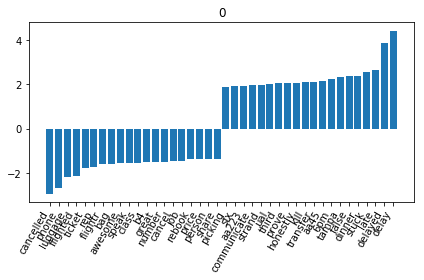

In [66]:
#Words importance
w = pipe.named_steps['logit'].coef_
#w.shape
features = pipe.named_steps['vect'].get_feature_names()
"""
fig, axarr = plt.subplots(5,3, figsize=(15,15))
for i in range(w.shape[0]):
    plot_important_features(w[i,:].ravel(), np.array(features), top_n=10, ax=axarr[i%5,i//5])
    axarr[i%5,i//5].set_title(i)
fig.tight_layout()
"""
fig = plt.figure()
ax = plt.gca()
plot_important_features(w[0,:].ravel(), np.array(features), top_n=20, ax=ax)
ax.set_title(0)
fig.tight_layout()

Unsurprisingly, we can see that words delay, delayed and are the most positively important. 
Let's now proceed to some parameter tuning. 
We have 3 main parts for our model (the 3 steps of our pipeline). Ideally, with infinite time and processing power, we would tune the 3 parts jointly. However, to limit the time, we will tune them separately.

## Parameters tuning

I started by refining my preprocessor (skipped here) and then decided to see in reducing the feature space by discarding nfrequent word would improve performance by reducing overfitting (Did not work).

### Tuning the min count of words  (feature selection)

In [67]:
processor = NLTKPreprocessor()
vect = CountVectorizer()
logit = LogisticRegression(class_weight='balanced')
pipe= Pipeline([('processor', processor), ('vect', vect) , ('logit', logit)])
param_grid = {
    #'logit__C':[.1, 1, 10, 10],
    'vect__min_df':[1, 3, 5]
}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91332, std: 0.00690, params: {'vect__min_df': 1},
  mean: 0.91185, std: 0.00614, params: {'vect__min_df': 3},
  mean: 0.91146, std: 0.00577, params: {'vect__min_df': 5}],
 {'vect__min_df': 1},
 0.9133238440752892)

The next step was tuning different models as the last step of my pipeline to try to improve performance. A lot more work could be done on the preprocessor to better tokenize words but my main focus here was really playing wit the models ad their parameters.

# Logistic regression
I started with the logisting regression for which I tried L1 and L2 penalty with different Cs

In [224]:

processor = NLTKPreprocessor()
vect = CountVectorizer(min_df=1)
logit = LogisticRegression(class_weight='balanced')
pipe= Pipeline([('processor', processor), ('vect', vect) , ('logit', logit)])
param_grid = {
    #'vect__min_df':[1, 3, 5],
    'logit__penalty':['l1', 'l2'],
    'logit__C':[.1, 1, 10, 100],
    
}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: 0.77134, std: 0.01751, params: {'logit__C': 0.1, 'logit__penalty': 'l1'},
  mean: 0.78004, std: 0.01981, params: {'logit__C': 0.1, 'logit__penalty': 'l2'},
  mean: 0.78484, std: 0.02061, params: {'logit__C': 1, 'logit__penalty': 'l1'},
  mean: 0.78500, std: 0.01910, params: {'logit__C': 1, 'logit__penalty': 'l2'},
  mean: 0.75120, std: 0.01368, params: {'logit__C': 10, 'logit__penalty': 'l1'},
  mean: 0.76528, std: 0.02128, params: {'logit__C': 10, 'logit__penalty': 'l2'},
  mean: 0.71575, std: 0.01251, params: {'logit__C': 100, 'logit__penalty': 'l1'},
  mean: 0.72774, std: 0.01732, params: {'logit__C': 100, 'logit__penalty': 'l2'}],
 {'logit__C': 1, 'logit__penalty': 'l2'},
 0.7849957504260902)

# Xgboost

The Xgboost algorithm is very powerful but it comes with a lot of parameters. I have found that tuning them can really goes a long way.
Since this algorithm can be overwhelming at first, I would advice you to go to this very good tutorial : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
whose guidelines  taught made a lot of sense.

## Tuning the number of trees

In [75]:
processor = NLTKPreprocessor(remove_stopwords=False)
vect = CountVectorizer(min_df=1)
pipe= Pipeline([('processor', processor), ('vect', vect) ])
X_vect = pipe.fit_transform(X, y)#.astype(np.float64)


In [15]:
X_vect = X_vect.astype(np.float64)

In [112]:
def get_resume(X_vect, pipe, ascending = False, n = None):
    feature_names = pipe.named_steps['vect'].get_feature_names()

    resume = pd.DataFrame(columns = feature_names, data = X_vect.toarray()).sum()

    if(n):
        return resume.sort_values(ascending = ascending)[:n]

    return resume

In [113]:
get_resume(X_vect, pipe, n=50)

toperson0    16475
to            8621
be            8271
the           6015
city0         5195
flight        4632
you           4349
for           3979
on            3792
and           3709
hashtag0      3276
my            3259
have          2706
in            2584
it            2528
of            2113
get           2066
me            1894
your          1743
that          1733
can           1657
do            1589
not           1532
with          1523
delay0        1483
at            1482
no            1463
this          1393
we            1284
but           1237
from          1201
link0         1154
thanks        1071
now           1026
service       1002
an             980
time           975
just           974
customer       938
help           936
so             884
delay          881
what           816
call           789
will           771
they           765
bag            756
fly            753
go             751
wait           744
dtype: int64

In [24]:
early_stopping = 10
params = {'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 
          'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':['error', 'auc'], 'nthread':1,
         'scale_pos_weight': 1/np.mean(y)}

xg_train = xgb.DMatrix(X_vect, label=y)
cv = xgb.cv(params, xg_train, 5000, folds=5, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.787326+0.0321552	train-error:0.20123+0.0717506	test-auc:0.754716+0.0314314	test-error:0.215915+0.0769983
[1]	train-auc:0.813246+0.0298237	train-error:0.161373+0.0726258	test-auc:0.791443+0.0235292	test-error:0.172678+0.0777422
[2]	train-auc:0.851325+0.0118869	train-error:0.141189+0.0525134	test-auc:0.830985+0.00235097	test-error:0.15123+0.0546737
[3]	train-auc:0.864166+0.0116582	train-error:0.180977+0.0484933	test-auc:0.838182+0.00621616	test-error:0.195014+0.0495841
[4]	train-auc:0.867922+0.0168673	train-error:0.192555+0.056635	test-auc:0.842977+0.00948308	test-error:0.206489+0.0599005
[5]	train-auc:0.872589+0.016542	train-error:0.157992+0.0605423	test-auc:0.848001+0.00909308	test-error:0.170902+0.0623119
[6]	train-auc:0.88129+0.0089077	train-error:0.179542+0.0535956	test-auc:0.85839+0.00625447	test-error:0.193716+0.0564505
[7]	train-auc:0.88721+0.00596501	train-error:0.177459+0.0561925	test-auc:0.864093+0.004496	test-error:0.192691+0.0569827
[8]	train-auc:0.891504+0.0

In [28]:
#1st round of tuning

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.90375, std: 0.01353, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.90313, std: 0.01309, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.90457, std: 0.01322, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.91170, std: 0.01155, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.91062, std: 0.01240, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.91403, std: 0.01185, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.91308, std: 0.01264, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.91349, std: 0.01235, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.91512, std: 0.01200, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.91322, std: 0.01042, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.91526, std: 0.01034, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.91642, std: 0.01233, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 5

In [29]:
#best params both borders so we search higer
param_test1 = {
 'max_depth':[10, 12, 14],
 'min_child_weight':[5, 7, 9]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91729, std: 0.01014, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.91760, std: 0.01168, params: {'max_depth': 10, 'min_child_weight': 7},
  mean: 0.91797, std: 0.01042, params: {'max_depth': 10, 'min_child_weight': 9},
  mean: 0.91625, std: 0.01050, params: {'max_depth': 12, 'min_child_weight': 5},
  mean: 0.91837, std: 0.01106, params: {'max_depth': 12, 'min_child_weight': 7},
  mean: 0.91845, std: 0.00946, params: {'max_depth': 12, 'min_child_weight': 9},
  mean: 0.91650, std: 0.00896, params: {'max_depth': 14, 'min_child_weight': 5},
  mean: 0.91785, std: 0.01087, params: {'max_depth': 14, 'min_child_weight': 7},
  mean: 0.91856, std: 0.01157, params: {'max_depth': 14, 'min_child_weight': 9}],
 {'max_depth': 14, 'min_child_weight': 9},
 0.9185571698866497)

In [30]:
#best params both borders so we search higer
param_test1 = {
 'max_depth':[14, 15, 16],
 'min_child_weight':[11, 15, 19]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91876, std: 0.01052, params: {'max_depth': 14, 'min_child_weight': 11},
  mean: 0.91776, std: 0.00823, params: {'max_depth': 14, 'min_child_weight': 15},
  mean: 0.91779, std: 0.01103, params: {'max_depth': 14, 'min_child_weight': 19},
  mean: 0.91799, std: 0.00933, params: {'max_depth': 15, 'min_child_weight': 11},
  mean: 0.91773, std: 0.00985, params: {'max_depth': 15, 'min_child_weight': 15},
  mean: 0.91776, std: 0.00958, params: {'max_depth': 15, 'min_child_weight': 19},
  mean: 0.91766, std: 0.00985, params: {'max_depth': 16, 'min_child_weight': 11},
  mean: 0.91845, std: 0.00909, params: {'max_depth': 16, 'min_child_weight': 15},
  mean: 0.91825, std: 0.01065, params: {'max_depth': 16, 'min_child_weight': 19}],
 {'max_depth': 14, 'min_child_weight': 11},
 0.918757717254827)

In [32]:
#finetuning min_child_weight by reducing steps
param_test1 = {
 
 'min_child_weight':[13, 14, 15]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91920, std: 0.00866, params: {'min_child_weight': 13},
  mean: 0.91905, std: 0.00843, params: {'min_child_weight': 14},
  mean: 0.91776, std: 0.00823, params: {'min_child_weight': 15}],
 {'min_child_weight': 13},
 0.91920035642579)

### Tuning gamma (minimun loss reduction to make a split)

In [34]:
param_test1 = {
 
 'gamma': [10, 20, 50, 100]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=14,
 min_child_weight=13, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91984, std: 0.00856, params: {'gamma': 10},
  mean: 0.92033, std: 0.00923, params: {'gamma': 20},
  mean: 0.91254, std: 0.01211, params: {'gamma': 50},
  mean: 0.89936, std: 0.01454, params: {'gamma': 100}],
 {'gamma': 20},
 0.9203299253010236)

### Tuning subsample and colsample_bytree

In [35]:
param_test1 = {
 
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.7, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91891, std: 0.01010, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.92095, std: 0.01096, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.92105, std: 0.00957, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.92219, std: 0.01019, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.91943, std: 0.01013, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.92033, std: 0.00923, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.92105, std: 0.00917, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.92134, std: 0.00994, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.91916, std: 0.00885, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.91988, std: 0.00997, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.92013, std: 0.00958, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.92079, std: 0.00878, params: {'colsample_bytree': 0.8, 'subsample'

In [37]:
#fine-tunning col_subsample_bytree
param_test1 = {
 

 'colsample_bytree':[i/10.0 for i in range(2,5)]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = 1/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91949, std: 0.01253, params: {'colsample_bytree': 0.2},
  mean: 0.92220, std: 0.01029, params: {'colsample_bytree': 0.3},
  mean: 0.92265, std: 0.01150, params: {'colsample_bytree': 0.4}],
 {'colsample_bytree': 0.4},
 0.9226487759435736)

### Tuning Regularization Parameters

In [42]:
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=61, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=-1, seed=27, scale_pos_weight = (1- np.mean(y))/np.mean(y))

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92314, std: 0.01102, params: {'reg_alpha': 1e-05},
  mean: 0.92318, std: 0.01094, params: {'reg_alpha': 0.01},
  mean: 0.92290, std: 0.01057, params: {'reg_alpha': 0.1},
  mean: 0.92188, std: 0.01129, params: {'reg_alpha': 1},
  mean: 0.89599, std: 0.01668, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.9231790171674564)

### Retuning the number of trees with a reduced learning rate to reduce variance

In [98]:
early_stopping = 10
params = {'eta': 0.1, 'max_depth': 14, 'subsample': 0.9, 'colsample_bytree': 0.4, 
          'objective': 'binary:logistic', 'seed': 12345, 'silent': 1, 'eval_metric':['error', 'auc'], 'nthread':1,
         'scale_pos_weight': 1/np.mean(y), 'reg_alpha':0.1, 'gamma': 20}

xg_train = xgb.DMatrix(X_vect, label=y)
cv = xgb.cv(params, xg_train, 5000, folds=5, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.819446+0.0178806	train-error:0.245799+0.0706549	test-auc:0.767934+0.0224427	test-error:0.263798+0.0773849
[1]	train-auc:0.882387+0.0213404	train-error:0.188934+0.0411122	test-auc:0.831802+0.0248598	test-error:0.21332+0.0432277
[2]	train-auc:0.901486+0.0208899	train-error:0.179235+0.0476842	test-auc:0.850496+0.022933	test-error:0.200137+0.0459522
[3]	train-auc:0.909917+0.023141	train-error:0.172131+0.0378193	test-auc:0.861715+0.0284715	test-error:0.192486+0.0372449
[4]	train-auc:0.924261+0.00867757	train-error:0.160724+0.0300463	test-auc:0.88061+0.0106593	test-error:0.182855+0.0303133
[5]	train-auc:0.927617+0.00998393	train-error:0.151161+0.0247658	test-auc:0.88586+0.0106756	test-error:0.172268+0.0258579
[6]	train-auc:0.930855+0.00848786	train-error:0.14054+0.0209085	test-auc:0.891235+0.0121375	test-error:0.159631+0.015445
[7]	train-auc:0.933549+0.00766836	train-error:0.139925+0.0285864	test-auc:0.894487+0.0129729	test-error:0.159768+0.0272248
[8]	train-auc:0.938664+0.00

[66]	train-auc:0.965636+0.00186749	train-error:0.097131+0.00175681	test-auc:0.925572+0.00328839	test-error:0.114891+0.00327125
[67]	train-auc:0.965872+0.00197403	train-error:0.096892+0.00177521	test-auc:0.92569+0.00337467	test-error:0.114891+0.00293831
[68]	train-auc:0.966237+0.00191202	train-error:0.0962773+0.00144	test-auc:0.925752+0.00343833	test-error:0.114481+0.00281159
[69]	train-auc:0.966464+0.00171551	train-error:0.0963453+0.00123333	test-auc:0.925931+0.00356514	test-error:0.114345+0.00306691
[70]	train-auc:0.966583+0.00173617	train-error:0.0963797+0.00133408	test-auc:0.926167+0.00369475	test-error:0.114686+0.00320204
[71]	train-auc:0.966673+0.00167199	train-error:0.0958677+0.00178725	test-auc:0.926255+0.00373241	test-error:0.114481+0.00281159
[72]	train-auc:0.966683+0.00165998	train-error:0.0959357+0.00181818	test-auc:0.926202+0.00369511	test-error:0.114276+0.00288045
[73]	train-auc:0.966732+0.00166305	train-error:0.095936+0.0018974	test-auc:0.926301+0.00376843	test-error:0.11

### Analysing the element misclassified by our model

In [157]:
estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=109, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=1, seed=27, scale_pos_weight = 1/np.mean(y))

X_train, X_test, y_train, y_test = train_test_split(X_vect,y, stratify=y)
estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=13, missing=None, n_estimators=109,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=8.792792792792792,
       seed=27, silent=True, subsample=0.9)

In [158]:
y_hat = estimator.predict(X_test)

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [159]:
#Confusion Matrix
confusion_matrix(y_test, y_hat, labels=[1,0])

array([[ 344,   72],
       [ 355, 2889]], dtype=int64)

In [160]:
comp = (y_hat != y_test) & (y_test == 1)
idx = comp[comp == True].index
misclassified = list(X.iloc[idx])
for i, item in enumerate(misclassified):
    print('{} : {}'.format(i, item))

0 : @united gates were DEFINITELY NOT FULL. We were parked and wheels were chocked. Customer service called it an "UNMET ARRIVAL"!!
1 : @USAirways I will send an email with details Late Flightr. Thank you for responding.
2 : @JetBlue 117 days maybe.
3 : @USAirways US 728/Feb 21. Ground power shorts again for the third time. Weary German passenger deplanes. Makes me jealous. Auf wiedersehen!
4 : @VirginAmerica spending my birthday night with you, DAL-DCA. Get me home!
5 : @JetBlue flight 348 is a freaking nightmare tonight #sittingonthetarmac #delay
6 : @USAirways pilot forgets to show up to work and Ricky J (gate agent) gives customers attitude. #usairwaysfail
7 : @USAirways - you kind of screwed my day up, at least it was outbound, but you did save it by stranding me in a @RenHotels @MarriottRewards
8 : @AmericanAir between your airline and @united I've now spent three extra days traveling (DOMESTIC) and spent hundreds of dollars...
9 : @SouthwestAir you're killing me!! always #delaye

In [156]:
processed_misclassified = process.transform(misclassified)
for i, item in enumerate(processed_misclassified):
    print('{} : {}'.format(i, item))

0 : toperson0 hey what s happen with hashtag0 zurich city0 appears to have squawk 7700 and land at london heathrow
1 : toperson0 there be seat but after wait on hold for delay0 they be go now she have to stay another night in charleston very pricy
2 : toperson0 117 day maybe
3 : toperson0 seriously buy some wd40 for a319 operate flight 634 from city0 to phoenix every seat squeak w every shift still on ground
4 : toperson0 finally about to take off thanks for the customer service by the g8 rep c17 city0 any idea what cause the system failure
5 : toperson0 the most frustrating fly experience one continuous i dunno what time you will leave today dunno that s code for
6 : toperson0 can t get back lose time
7 : toperson0 finally get through after delay0 and all set thanks
8 : toperson0 stop picking on u city0 link0
9 : toperson0 you stand me up last night but i m give you a second chance i m just a boy tweet an airline ask them to fly him home
10 : toperson0 even toperson0 respond quicker v

## Fitting and Saving the final Model

In [120]:
processor = NLTKPreprocessor()
vect = CountVectorizer()
boost = xgb.XGBClassifier( learning_rate =0.1, n_estimators=109, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=1, seed=27, scale_pos_weight = 1/np.mean(y))
pipe= Pipeline([('processor', processor), ('vect', vect) , ('boost', boost)])


pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('processor', NLTKPreprocessor(lower=True,
         punct={'/', '=', '|', '{', '*', "'", '`', '-', '\\', ',', '@', '}', '>', '[', '_', '$', '%', '+', ')', '#', '&', '~', '!', '?', ':', '^', '(', ';', '"', '.', ']', '<'},
         remove_stopwords=True,
         stopwords={"you're", 'between',...a=0, reg_lambda=1, scale_pos_weight=8.792792792792792,
       seed=27, silent=True, subsample=0.9))])

In [123]:
joblib.dump(pipe, '../saved_models/xgboost.pkl') 

['../saved_models/xgboost.pkl']

# SVM
I tune the penality term and the gamma for this one

In [170]:
param_test1 = {
 'C': [10, 30, 100],
 'gamma': [x/X_vect.shape[1] for x in [50, 100, 300]]
}

estimator = SVC(class_weight='balanced')

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect,y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91683, std: 0.00925, params: {'C': 10, 'gamma': 0.005606638259699484},
  mean: 0.91273, std: 0.00906, params: {'C': 10, 'gamma': 0.011213276519398968},
  mean: 0.90576, std: 0.00913, params: {'C': 10, 'gamma': 0.03363982955819691},
  mean: 0.90643, std: 0.00994, params: {'C': 30, 'gamma': 0.005606638259699484},
  mean: 0.89913, std: 0.01067, params: {'C': 30, 'gamma': 0.011213276519398968},
  mean: 0.90089, std: 0.00987, params: {'C': 30, 'gamma': 0.03363982955819691},
  mean: 0.89019, std: 0.01132, params: {'C': 100, 'gamma': 0.005606638259699484},
  mean: 0.89087, std: 0.01072, params: {'C': 100, 'gamma': 0.011213276519398968},
  mean: 0.89761, std: 0.01096, params: {'C': 100, 'gamma': 0.03363982955819691}],
 {'C': 10, 'gamma': 0.005606638259699484},
 0.9168252645709293)

In [175]:
param_test1 = {
 
 'gamma': [x/X_vect.shape[1] for x in [6, 8, 10]]
}

estimator = SVC(C = 10, class_weight='balanced')

grid = GridSearchCV(estimator=estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=5 )

grid.fit(X_vect, y)
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92130, std: 0.00993, params: {'gamma': 0.0006727965911639381},
  mean: 0.92111, std: 0.00952, params: {'gamma': 0.0008970621215519175},
  mean: 0.92084, std: 0.00921, params: {'gamma': 0.001121327651939897}],
 {'gamma': 0.0006727965911639381},
 0.9212965566722794)

# Light GBM
The light GBM is another boost algorithm but it defers from the XGBoost in that tree are grown by leafs instead of by level (so you can get an imbalanced tree). For us this mainly means that the number of leafs because amore accurate way to control the complexity of the model since there is no straightforward mappingto max_depth anymore).
Besides that, tuning the rest of the parameters is more or less the same game.

In [23]:
#Tuning the number of trees for a given learning rate
params = {'max_depth' : -1, 'objective': 'binary', 'num_leaves': 64, 'learning_rate': 0.1, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 'reg_alpha': 5, 
          'reg_lambda': 10, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'class_weight': 'balanced',
          'num_class' : 1, 'metric' : 'binary_error'}
pos_weight = 1-np.mean(y)
weight = y.apply(lambda x : pos_weight if x == 1 else 1 - pos_weight)
dataset = lgb.Dataset(data=X_vect, label=y, weight=weight)
cv = lgb.cv(params=params, train_set=dataset, num_boost_round=1000, nfold=10, stratified=True,
                early_stopping_rounds=10, metrics=['binary', 'auc'], verbose_eval=True)

[1]	cv_agg's binary_logloss: 0.673076 + 0.00178873	cv_agg's auc: 0.775327 + 0.0283684
[2]	cv_agg's binary_logloss: 0.648858 + 0.00274277	cv_agg's auc: 0.842357 + 0.0196507
[3]	cv_agg's binary_logloss: 0.626243 + 0.00427477	cv_agg's auc: 0.850015 + 0.0194766
[4]	cv_agg's binary_logloss: 0.607964 + 0.00597687	cv_agg's auc: 0.854476 + 0.0200179
[5]	cv_agg's binary_logloss: 0.590809 + 0.00765991	cv_agg's auc: 0.8557 + 0.0200911
[6]	cv_agg's binary_logloss: 0.577598 + 0.00895329	cv_agg's auc: 0.857441 + 0.0203729
[7]	cv_agg's binary_logloss: 0.568579 + 0.00933776	cv_agg's auc: 0.860863 + 0.0204203
[8]	cv_agg's binary_logloss: 0.557027 + 0.0105478	cv_agg's auc: 0.861748 + 0.0209941
[9]	cv_agg's binary_logloss: 0.547401 + 0.011677	cv_agg's auc: 0.86167 + 0.0205548
[10]	cv_agg's binary_logloss: 0.539468 + 0.012528	cv_agg's auc: 0.862497 + 0.0204581
[11]	cv_agg's binary_logloss: 0.531782 + 0.0134918	cv_agg's auc: 0.86328 + 0.0204828
[12]	cv_agg's binary_logloss: 0.526752 + 0.0141528	cv_agg's au

In [26]:
#Tunning 
params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 64, 'learning_rate': 0.05, 
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 5, 'reg_lambda': 10, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 
          'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error'}

gridParams = {
    'num_leaves': [50, 70, 96, 110],
    'min_data_in_leaf' : [1, 2, 3, 4, 5],

    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          n_jobs = 5, # Updated from 'nthread' 
          silent = True,
          **params)
grid = GridSearchCV(estimator=mdl, param_grid = gridParams, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=10 )

grid.fit(X_vect,y)#, categorical_feature=range(X_vect.shape[1]))
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91231, std: 0.01938, params: {'min_data_in_leaf': 1, 'num_leaves': 50},
  mean: 0.91298, std: 0.01963, params: {'min_data_in_leaf': 1, 'num_leaves': 70},
  mean: 0.91339, std: 0.01964, params: {'min_data_in_leaf': 1, 'num_leaves': 96},
  mean: 0.91270, std: 0.01983, params: {'min_data_in_leaf': 1, 'num_leaves': 110},
  mean: 0.91225, std: 0.01969, params: {'min_data_in_leaf': 2, 'num_leaves': 50},
  mean: 0.91316, std: 0.01982, params: {'min_data_in_leaf': 2, 'num_leaves': 70},
  mean: 0.91356, std: 0.01930, params: {'min_data_in_leaf': 2, 'num_leaves': 96},
  mean: 0.91307, std: 0.01991, params: {'min_data_in_leaf': 2, 'num_leaves': 110},
  mean: 0.91238, std: 0.01947, params: {'min_data_in_leaf': 3, 'num_leaves': 50},
  mean: 0.91338, std: 0.01949, params: {'min_data_in_leaf': 3, 'num_leaves': 70},
  mean: 0.91304, std: 0.01935, params: {'min_data_in_leaf': 3, 'num_leaves': 96},
  mean: 0.91331, std: 0.01939, params: {'min_data_in_leaf': 3, 'num_leaves': 110},
  mean: 0.912

### Tuning max_bin, subsampling and bagging parameters

In [28]:
#finetuning the number of leaves
params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 96, 'learning_rate': 0.05, 
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 5, 'reg_lambda': 10, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 
          'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error', 'min_data_in_leaf':2}

gridParams = {
    'max_bin': [150, 220, 300, 400, 512],
    'subsample': [x/10 for x in range(5, 11)],
    'colsample_bytree': [x/10 for x in range(5, 11)],
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          n_jobs = 5, # Updated from 'nthread' 
          silent = True,
          **params)
grid = GridSearchCV(estimator=mdl, param_grid = gridParams, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=10 )

grid.fit(X_vect,y)#, categorical_feature=range(X_vect.shape[1]))
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.90779, std: 0.02203, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 0.5},
  mean: 0.91075, std: 0.02123, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 0.6},
  mean: 0.91178, std: 0.02085, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 0.7},
  mean: 0.91238, std: 0.02120, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 0.8},
  mean: 0.91248, std: 0.02045, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 0.9},
  mean: 0.91302, std: 0.02031, params: {'colsample_bytree': 0.5, 'max_bin': 150, 'subsample': 1.0},
  mean: 0.90779, std: 0.02203, params: {'colsample_bytree': 0.5, 'max_bin': 220, 'subsample': 0.5},
  mean: 0.91075, std: 0.02123, params: {'colsample_bytree': 0.5, 'max_bin': 220, 'subsample': 0.6},
  mean: 0.91178, std: 0.02085, params: {'colsample_bytree': 0.5, 'max_bin': 220, 'subsample': 0.7},
  mean: 0.91238, std: 0.02120, params: {'colsample_bytree': 0.5, 'max_bin': 220, 'subsample': 0.8},


### Tuning regularization parameters

In [31]:
#finetuning the number of leaves
params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 96, 'learning_rate': 0.05, 
          'max_bin': 150, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': .1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 
          'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error', 'min_data_in_leaf':2}

gridParams = {
    #'reg_alpha': [.01, .1, 1, 10, 100],
    #'reg_lambda': [.01, .1, 1, 10, 100],
    'min_split_gain': [.01, .05, .1]
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          n_jobs = 5, # Updated from 'nthread' 
          silent = True,
          **params)
grid = GridSearchCV(estimator=mdl, param_grid = gridParams, scoring='roc_auc',n_jobs=1,iid=False, 
                    cv=10 )

grid.fit(X_vect,y)#, categorical_feature=range(X_vect.shape[1]))
grid.grid_scores_, grid.best_params_, grid.best_score_

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91628, std: 0.01757, params: {'min_split_gain': 0.01},
  mean: 0.91606, std: 0.01747, params: {'min_split_gain': 0.05},
  mean: 0.91712, std: 0.01713, params: {'min_split_gain': 0.1}],
 {'min_split_gain': 0.1},
 0.9171226353707322)

### Retuning numberof trees with new found parameters and lower learning rate

In [41]:
params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 96, 'learning_rate': 0.05, 
          'max_bin': 150, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': .1, 'reg_lambda': 1, 'min_split_gain': 0.1, 'min_child_weight': 1, 'min_child_samples': 5, 
          'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error', 'min_data_in_leaf':2}
pos_weight = 1-np.mean(y)
weight = y.apply(lambda x : pos_weight if x == 1 else 1 - pos_weight)
dataset = lgb.Dataset(data=X_vect, label=y, weight=weight)
cv = lgb.cv(params=params, train_set=dataset, num_boost_round=1000, nfold=10, stratified=True,
                early_stopping_rounds=10, metrics=['binary', 'auc'], verbose_eval=True)

C:\Users\franck\Anaconda3\envs\nlp\lib\site-packages\lightgbm\engine.py:390: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	cv_agg's binary_logloss: 0.679053 + 0.00119989	cv_agg's auc: 0.797744 + 0.0254859
[2]	cv_agg's binary_logloss: 0.662025 + 0.00200461	cv_agg's auc: 0.857955 + 0.0209377
[3]	cv_agg's binary_logloss: 0.645534 + 0.00292012	cv_agg's auc: 0.869148 + 0.0203439
[4]	cv_agg's binary_logloss: 0.631154 + 0.00384208	cv_agg's auc: 0.874236 + 0.0201445
[5]	cv_agg's binary_logloss: 0.617221 + 0.00471959	cv_agg's auc: 0.875265 + 0.019612
[6]	cv_agg's binary_logloss: 0.605083 + 0.00564029	cv_agg's auc: 0.876878 + 0.0191486
[7]	cv_agg's binary_logloss: 0.596661 + 0.00575039	cv_agg's auc: 0.878984 + 0.0184191
[8]	cv_agg's binary_logloss: 0.585463 + 0.00630052	cv_agg's auc: 0.879395 + 0.0174919
[9]	cv_agg's binary_logloss: 0.575347 + 0.00699481	cv_agg's auc: 0.879574 + 0.0175068
[10]	cv_agg's binary_logloss: 0.566443 + 0.00789113	cv_agg's auc: 0.88062 + 0.0181459
[11]	cv_agg's binary_logloss: 0.557513 + 0.00845265	cv_agg's auc: 0.88154 + 0.017927
[12]	cv_agg's binary_logloss: 0.551682 + 0.0089464	cv_ag

I noticed that for some reason the LGB crossvalidation framework gives me worse results than the scikit-learn one. This would be work investigating in a challenge setting for example but I decided to try not to spend to much time on this exercise.

# Stacking
Finally, reviewing the state-of-the-art model recommended by people for Kaggle challenges and such, I noticed that stacking different models brought significant boost in performance more often that not. Since I had already build a bunh of models, I decided to stack them. 
The philosophy behind stacking is a little bit involved but one of the main takeway is that we are going to use the prediction of ours models as features to build a second model. However, since learning the 1st level models the usual way would make use of dependent variables, inducing a huge information leakage, we are going the make out of fold predictions using cross validation for each of the 1st model. We will then train our 2nd layer model on those out-of-fold predictions. We are also  going to train 1st layer models on the whole training set but we are going to use them to predict the 2nd layer features of the test set.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_vect,y, stratify=y)

columns = ['SVM', 'Boost', 'Logit', 'LGB']
#columns = ['Logit', 'Boost', 'LGB']
train_meta = pd.DataFrame(np.nan, index=range(X_train.shape[0]), columns=columns)
test_meta = pd.DataFrame(np.nan, index=range(X_test.shape[0]), columns=columns)

skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
for sub_train_index, sub_val_index in skf.split(X_train, y_train):
    X_train_sub = X_train[sub_train_index,:]
    y_train_sub = y_train.iloc[sub_train_index]
    X_val_sub = X_train[sub_val_index,:]
    y_val_sub = y_train.iloc[sub_val_index]
    
    
    svm = SVC(C=10, gamma=8/X_vect.shape[1], class_weight='balanced', probability=True)
    svm.fit(X_train_sub, y_train_sub)
    train_meta['SVM'][sub_val_index] = svm.predict_proba(X_val_sub)[:,1].flatten()
    test_meta['SVM'] = svm.predict_proba(X_test)[:,:1].flatten()
    
    
    logit = LogisticRegression(C=1, class_weight='balanced')
    logit.fit(X_train_sub, y_train_sub)
    train_meta['Logit'][sub_val_index] = logit.predict_proba(X_val_sub)[:,1].flatten()
    test_meta['Logit'] = logit.predict_proba(X_test)[:,1].flatten()
    
    
    boost = xgb.XGBClassifier( learning_rate =0.1, n_estimators=109, max_depth=14,
     min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.4,
     objective= 'binary:logistic', nthread=1, seed=27, scale_pos_weight = (1 - np.mean(y))/np.mean(y)
                             )
    boost.fit(X_train_sub, y_train_sub)
    train_meta['Boost'][sub_val_index] = boost.predict_proba(X_val_sub)[:,1].flatten()
    test_meta['Boost'] = boost.predict_proba(X_test)[:,1].flatten()         
    
    params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 96, 'learning_rate': 0.05, 
          'max_bin': 150, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': .1, 'reg_lambda': 1, 'min_split_gain': 0.1, 'min_child_weight': 1, 'min_child_samples': 5, 
          'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error', 'min_data_in_leaf':2}
    mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          n_jobs = 5, # Updated from 'nthread' 
          silent = True,
          **params)
    mdl.fit(X_train_sub, y_train_sub)
    train_meta['LGB'][sub_val_index] = mdl.predict_proba(X_val_sub)[:,1].flatten()
    test_meta['LGB'] = mdl.predict_proba(X_test)[:,1].flatten()

In [70]:
final_svm = SVC(C=10, gamma=8/X_vect.shape[1], class_weight='balanced', probability=True)
final_svm.fit(X_train, y_train)
test_meta['SVM'] = final_svm.predict_proba(X_test)[:,:1].flatten()


final_logit = LogisticRegression(C=1, class_weight='balanced')
final_logit.fit(X_train, y_train)
test_meta['Logit'] = final_logit.predict_proba(X_test)[:,1].flatten()


final_boost = xgb.XGBClassifier( learning_rate =0.1, n_estimators=109, max_depth=14,
 min_child_weight=13, gamma=20, subsample=0.9, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=1, seed=27, scale_pos_weight = (1 - np.mean(y))/np.mean(y)
                         )
final_boost.fit(X_train, y_train)
test_meta['Boost'] = final_boost.predict_proba(X_test)[:,1].flatten()         

params = {'n_estimators':80, 'max_depth' : -1, 'objective': 'binary', 'num_leaves': 96, 'learning_rate': 0.05, 
      'max_bin': 150, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 
      'reg_alpha': .1, 'reg_lambda': 1, 'min_split_gain': 0.1, 'min_child_weight': 1, 'min_child_samples': 5, 
      'class_weight': 'balanced', 'num_class' : 1, 'metric' : 'binary_error', 'min_data_in_leaf':2}
final_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
      n_jobs = 5, # Updated from 'nthread' 
      silent = True,
      **params)
final_mdl.fit(X_train, y_train)
test_meta['LGB'] = final_mdl.predict_proba(X_test)[:,1].flatten()

In [71]:
final_estimator = LogisticRegressionCV(Cs=[.1, 1, 10], class_weight='balanced')
final_estimator.fit(train_meta, y_train)
final_prob = final_estimator.predict_proba(test_meta)[:,1].flatten()


final_boost_prob = final_boost.predict_proba(X_test)[:,1].flatten()
roc_auc = roc_auc_score(y_test, final_prob)
roc_auc_boost = roc_auc_score(y_test, final_boost_prob)
print('roc auc score Score: {}'.format(roc_auc))
print('roc auc score Score for Boosting: {}'.format(roc_auc_boost))

roc auc score Score: 0.9294674191406621
roc auc score Score for Boosting: 0.9247912566394765


We can see that the stacking provides a slight boost in the roc auc score. We would need to do another layer of crossvalidation to have a better estimation but given the rather small sample size this might prove unstable. Altough this might not seem like much, every littleimprovement might make a difference in settings like Kaggle competitions.
Finally, we can pickle the model (the models actually since we are going to use the stacked model) using scikit-learn joblib) to allow our command line program to call it to make it's predictions.
Since we did not include the preprocessing steps in the pipeline for the parametertuning, we are going to save each stepas it's own model and rebuild the pipeline from them at prediction time (without refitting it obviously)

In [76]:
#joblib.dump(pipe.named_steps['processor'], '../saved_models/processor.pkl')
#joblib.dump(pipe.named_steps['vect'], '../saved_models/vect.pkl')
joblib.dump(pipe, '../saved_models/pipe.pkl')
joblib.dump(final_svm, '../saved_models/final_svm.pkl')
joblib.dump(final_logit, '../saved_models/final_logit.pkl')
joblib.dump(final_mdl, '../saved_models/final_LGB.pkl')
joblib.dump(final_boost, '../saved_models/final_boost.pkl')
joblib.dump(final_estimator, '../saved_models/final_estimator.pkl')

                             

['../saved_models/final_estimator.pkl']